# Classical ML Models

---

<center><h2>Lesson 06</h2></center>


## Learning Objectives

By the end of this lesson you will be able to:

1. **Trace how information flows through Multi-Layer Perceptrons (MLPs)** from inputs to outputs, including forward and backward passes.
2. **Train, evaluate, and interpret** four core classical models (**Logistic Regression, MLPs, Random Forests, Gradient Boosting**) on both a biomedical (tabular) dataset and an image dataset.
3. **Compare strengths, weaknesses, and practical considerations** for each model family to select the right tool for a given problem.
4. **Experiment interactively** with hyperparameters and observe how they affect accuracy, calibration, and computation.

---


## Table of Contents

1. Introduction: Why Compare Classical Models?
2. Experiment Setup and Dataset
3. Logistic Regression Baseline
4. How Information Flows Through MLPs
5. Interactive MLP Playground
6. Random Forest Ensembles
7. Gradient Boosted Trees
8. Model Comparison Dashboard
9. Strengths & Weaknesses Cheat Sheet
10. Fashion-MNIST Benchmark
11. Reflection Prompts and Next Steps


## 1. Introduction: Why Compare Classical Models?

Well-chosen machine learning models often outperform ever more complex architectures. For many biomedical, IoT, or tabular business problems, **classical models** such as Logistic Regression, MLPs, Random Forests, and Gradient Boosted Trees remain competitive because they:

- Train quickly on laptops while still delivering strong accuracy.
- Provide transparent levers (hyperparameters) clinicians or analysts can reason about.
- Require less labeled data than deep CNNs or transformers.

Throughout this notebook we will:

- Build a shared dataset pipeline to ensure fair apples-to-apples comparisons.
- Explain _how_ each model transforms information.
- Run interactive experiments where you can edit hyperparameters, re-run cells, and immediately see the impact on metrics and plots.


## 2. Experiment Setup and Dataset

We will reuse a **tabular biomedical dataset** (Breast Cancer Wisconsin) with 30 diagnostic features. Using the same train/test split and evaluation utilities across models lets us do fair comparisons.

**Workflow overview**:

1. Import core libraries and configure visuals.
2. Load and inspect the dataset as a pandas `DataFrame` for interpretability.
3. Split the data, then scale features for algorithms (MLPs, Logistic Regression) that are sensitive to feature magnitude.
4. Create helper functions that standardize training, metric collection, and plotting.

Run the following cells to set up the environment.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

np.random.seed(42)
plt.style.use("seaborn-v0_8")
sns.set_palette("colorblind")


### ✏️ Exercise: Load and preprocess the [Breast Cancer Dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset)

#### **Prompt:**

Load the breast cancer dataset from scikit-learn as a dataframe called X, then preprocess the data and use scikit-learn's standard scalar to scale the data, storing it as X_scaled. Then us`e .head() to display the dataframe

Dataset shape: (569, 30)
Train size: (455, 30), Test size: (114, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


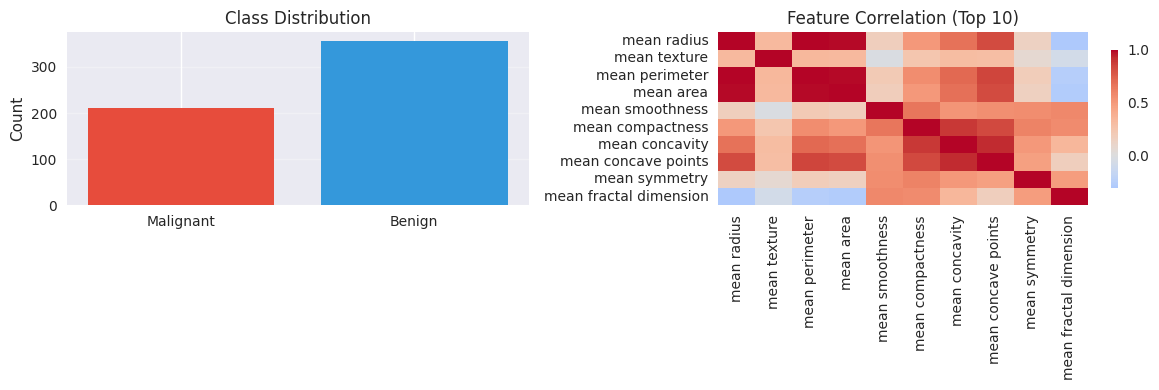

In [2]:
# Load dataset as a pandas DataFrame
data = load_breast_cancer(as_frame=True)
df = data.frame.copy()
X = df.drop(columns="target")
y = df["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
 )

# Scale features (fit on training set only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional full scaled DataFrame for inspection/visualization
X_scaled = pd.DataFrame(
    scaler.transform(X),
    columns=X.columns,
    index=X.index,
 )

print(f"Dataset shape: {X.shape}")
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
display(X.head())

# Quick visualization of key features
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
class_counts = y.value_counts().sort_index()
axes[0].bar(
    ["Malignant", "Benign"],
    [class_counts[0], class_counts[1]],
    color=["#e74c3c", "#3498db"],
)
axes[0].set_title("Class Distribution")
axes[0].set_ylabel("Count")
axes[0].grid(axis="y", alpha=0.3)

# Correlation heatmap for first 10 features
top_features = data.feature_names[:10]
corr_matrix = X[top_features].corr()
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    ax=axes[1],
    cbar_kws={"shrink": 0.8},
)
axes[1].set_title("Feature Correlation (Top 10)")

plt.tight_layout()
plt.show()

### Visualizing the Breast Cancer Dataset Features

Before training models, let's explore the dataset visually to understand:

- The distribution of features across classes (benign vs. malignant).
- Correlations between features that might inform feature engineering.
- Class balance to verify our stratified split worked correctly.

These visualizations help build intuition about which features might be most discriminative.

In [3]:
model_results = []
trained_models = {}


def plot_confusion_matrix(y_true, y_pred, title, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]
    if class_names is None or len(class_names) != n_classes:
        labels = np.unique(np.concatenate((np.asarray(y_true), np.asarray(y_pred))))
        class_names = [str(label) for label in labels]

    # Make multiclass confusion matrices readable (e.g., 10-class MNIST).
    fig_size = 4 if n_classes <= 2 else 5 if n_classes <= 4 else 7 if n_classes <= 6 else 10
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    sns.heatmap(
        cm,
        annot=(n_classes <= 6),
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def train_and_evaluate(name, estimator, X_train, y_train, X_test, y_test, class_names=None, results_store=None):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    roc = np.nan
    y_score = None
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X_test)
    elif hasattr(estimator, "decision_function"):
        y_score = estimator.decision_function(X_test)

    if y_score is not None:
        if np.ndim(y_score) == 1:
            roc = roc_auc_score(y_test, y_score)
        elif y_score.shape[1] == 2:
            roc = roc_auc_score(y_test, y_score[:, 1])
        else:
            roc = roc_auc_score(y_test, y_score, multi_class="ovr")

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC_AUC": roc,
        "Train size": len(X_train),
        "Test size": len(X_test),
    }

    target_results = model_results if results_store is None else results_store
    target_results.append(metrics)
    trained_models[name] = estimator

    print(f"\n{name} metrics:")
    for key in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]:
        value = metrics[key]
        print(f"  {key:>9}: {value:.3f}" if not np.isnan(value) else f"  {key:>9}: n/a")

    plot_confusion_matrix(y_test, y_pred, title=f"{name} Confusion Matrix", class_names=class_names)
    return estimator


### 🔍 Quick Data Sanity Check

- Are any features on drastically different scales? (Use `X.describe()` if you need evidence.)
- Try toggling `test_size` or `stratify` in the previous cell to see how sensitive downstream metrics are to the split.
- Consider saving `feature_names = data.feature_names` if you plan to inspect feature importances later.


## 3. Logistic Regression Baseline

Logistic Regression is a strong **first baseline** for classification.

- It learns a **linear decision boundary** in feature space.
- It outputs **probabilities** via the sigmoid (binary) or softmax (multi-class).
- With L2 regularization, it often performs surprisingly well on tabular biomedical data.

In this lesson we will train Logistic Regression alongside MLPs, Random Forests, and Gradient Boosting using the same evaluation helper so comparisons are fair.



Logistic Regression (L2) metrics:
   Accuracy: 0.982
  Precision: 0.982
     Recall: 0.982
         F1: 0.982
    ROC_AUC: 0.995


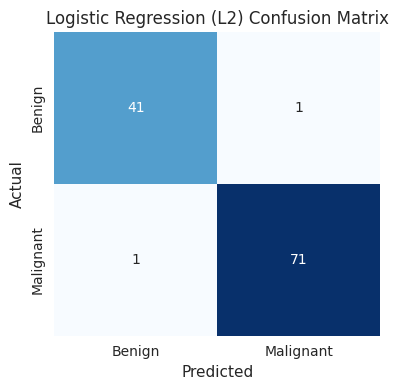

In [4]:
lr_classifier = LogisticRegression(
    solver="lbfgs",
    max_iter=2000,
    C=1.0,
    )

lr_model = train_and_evaluate(
    name="Logistic Regression (L2)",
    estimator=lr_classifier,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    class_names=["Benign", "Malignant"],
 )


## 4. How Information Flows Through MLPs

Multi-Layer Perceptrons process data through **stacked linear transformations** followed by **non-linear activations**. This alternating structure lets them learn complex, non-linear decision boundaries even when each individual neuron is simple.

### Forward Pass (Inference)

1. **Linear combination**: each neuron receives inputs $\mathbf{x}$ and computes $z = \mathbf{w}^T\mathbf{x} + b$.
2. **Activation**: a non-linearity (ReLU, tanh, logistic) outputs $a = \sigma(z)$ so that layers cannot be collapsed into a single linear map.
3. **Layer stacking**: the activations from layer $l$ become inputs to layer $l+1$. In matrix form:
   $$\mathbf{a}^{(l)} = \sigma\big(W^{(l)}\mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}\big)$$
4. **Output layer**: applies a task-specific function (softmax for multi-class classification, identity for regression) to generate predictions.

### Backward Pass (Learning)

- Compute loss $\mathcal{L}(\hat{y}, y)$ (cross-entropy in this notebook).
- **Backpropagation** reuses the chain rule to propagate gradients from the output layer back to each weight matrix $W^{(l)}$.
- **Optimizers** (Adam, SGD, LBFGS) update weights: $W^{(l)} \leftarrow W^{(l)} - \eta \cdot \nabla_{W^{(l)}} \mathcal{L}$.
- Gradients shrink or explode depending on network depth, activation choice, and scaling—hence our emphasis on standardized inputs.

### Key Hyperparameters to Watch

| Hyperparameter       | Impact                                                                      |
| -------------------- | --------------------------------------------------------------------------- |
| `hidden_layer_sizes` | Controls model capacity; too small underfits, too large overfits.           |
| `activation`         | Shapes non-linearity; `relu` is fast and sparse, `tanh` captures negatives. |
| `alpha`              | L2 regularization that discourages large weights.                           |
| `learning_rate_init` | Step size for gradient updates; combine with `max_iter`.                    |
| `batch_size`         | Balances stability vs. speed when using stochastic solvers.                 |

> **Remember:** MLPs excel when features are scaled and you have enough data to justify their flexibility, but they can be sensitive to noise and require careful tuning.


## 5. Interactive MLP Playground

We'll start with an MLP and capture its metrics. Rerun this cell after changing layer sizes, activations, or regularization to observe how the gradient-driven learning dynamics respond.



MLP (64-32 ReLU) metrics:
   Accuracy: 0.965
  Precision: 0.966
     Recall: 0.965
         F1: 0.965
    ROC_AUC: 0.994


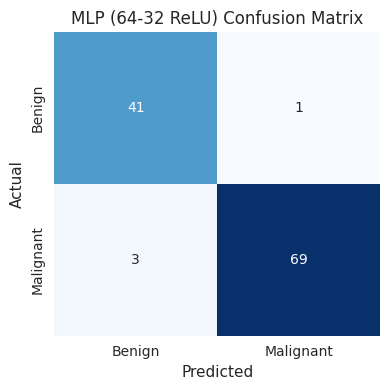

In [5]:
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=800,
    random_state=42,
)

mlp_model = train_and_evaluate(
    name="MLP (64-32 ReLU)",
    estimator=mlp_classifier,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    class_names=["Benign", "Malignant"],
)


### 🧪 Try It Yourself: MLP Experiments

- Swap `activation` between `"relu"`, `"tanh"`, and `"logistic"`.
- Add or remove hidden layers (e.g., `(128, 64, 32)` vs `(32,)`).
- Increase `alpha` to see how regularization combats overfitting.
- Reduce `max_iter` and observe convergence warnings—what does that tell you about optimization difficulty?


## 6. Random Forest Ensembles

Random Forests average predictions from many decorrelated decision trees. Each tree is trained on a bootstrap sample and uses a random subset of features when splitting, which reduces variance and overfitting.

**Strength highlights**

- Handle unscaled, mixed-type features out of the box.
- Offer built-in measures of feature importance.
- Parallelize easily by growing trees independently.

**Watch outs**

- Large forests can become memory-heavy.
- Interpretability decreases compared to single trees.
- High-dimensional sparse data may favor other models.



Random Forest (400 trees) metrics:
   Accuracy: 0.956
  Precision: 0.956
     Recall: 0.956
         F1: 0.956
    ROC_AUC: 0.994


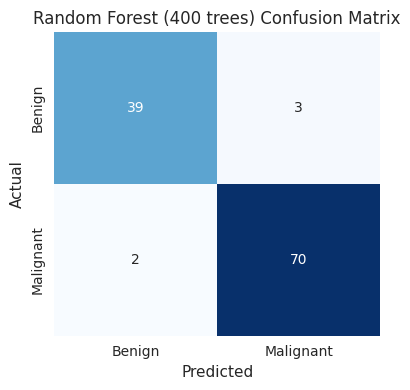

In [6]:
rf_classifier = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

rf_model = train_and_evaluate(
    name="Random Forest (400 trees)",
    estimator=rf_classifier,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    class_names=["Benign", "Malignant"],
)


**Try tweaking** `n_estimators`, `max_depth`, or `min_samples_split` to see how the bias/variance balance shifts. Smaller forests train fast but may be noisy; deeper trees often overfit without pruning.


## 7. Gradient Boosted Trees

Gradient Boosted Trees (we'll use `GradientBoostingClassifier`) build trees **sequentially**, where each new tree fits the residual errors of the ensemble so far. Unlike Random Forests (parallel, variance-reduction), boosting focuses on bias reduction.

Tunable levers:

- `learning_rate`: shrinkage applied to each tree's contribution.
- `n_estimators`: number of boosting stages.
- `max_depth`/`max_leaf_nodes`: complexity of each tree.

Boosting yields state-of-the-art results on many structured datasets but can take longer to tune and is more sensitive to noisy labels.



Gradient Boosting (300 stg) metrics:
   Accuracy: 0.956
  Precision: 0.957
     Recall: 0.956
         F1: 0.956
    ROC_AUC: 0.991


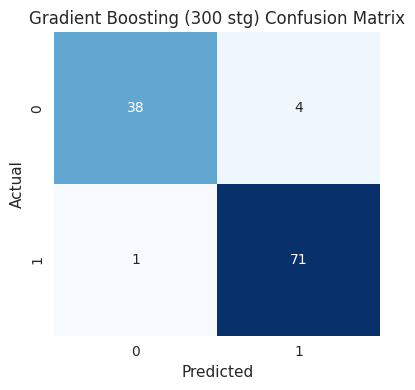

In [7]:
gb_classifier = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=3,
    random_state=42,
)

gb_model = train_and_evaluate(
    name="Gradient Boosting (300 stg)",
    estimator=gb_classifier,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)


**Exercise:** Lower `learning_rate` to `0.01` and compensate by increasing `n_estimators`. Does performance improve or plateau? Track training time, too—boosting is iterative.


## 8. Model Comparison Dashboard

Let's aggregate the metrics we collected and visualize how each algorithm performs side-by-side. Because every model saw the same train/test split, differences are driven by inductive biases rather than data luck.


In [8]:
results_df = pd.DataFrame(model_results).set_index("Model").sort_values("Accuracy", ascending=False)
results_df

,Accuracy,Precision,Recall,F1,ROC_AUC,Train size,Test size
Model,,,,,,,
Logistic Regression (L2),0.982456,0.982456,0.982456,0.982456,0.995370,455,114
MLP (64-32 ReLU),0.964912,0.965858,0.964912,0.965073,0.993717,455,114
Random Forest (400 trees),0.956140,0.956073,0.956140,0.956027,0.994378,455,114
Gradient Boosting (300 stg),0.956140,0.956869,0.956140,0.955776,0.991071,455,114


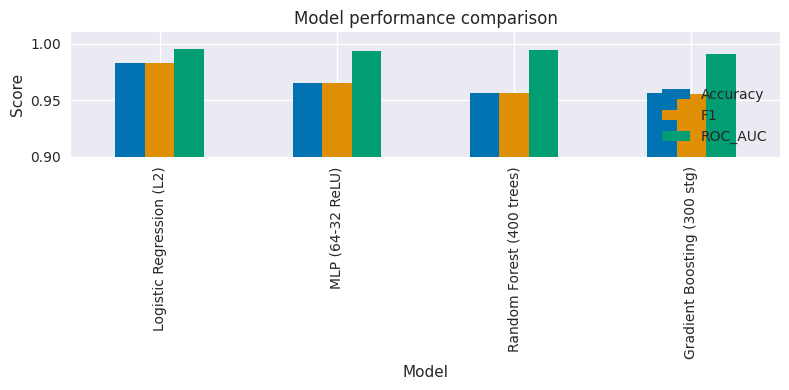

In [9]:
metrics_to_plot = ["Accuracy", "F1", "ROC_AUC"]

fig, ax = plt.subplots(figsize=(8, 4))
results_df[metrics_to_plot].plot(kind="bar", ax=ax)
ax.set_ylim(0.9, 1.01)
ax.set_ylabel("Score")
ax.set_title("Model performance comparison")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


**Reading the dashboard**

- Evaluate consistency across metrics; a model with top accuracy but poor recall might miss malignant cases.
- If two models tie, prefer the one that is simpler to explain/deploy for your stakeholders.
- Re-run earlier cells with modified hyperparameters and watch this table update in real time.


## 9. Strengths & Weaknesses Cheat Sheet

The table below summarizes practical considerations when choosing among these classical models. Use it when designing new experiments or justifying choices to collaborators.


In [10]:
comparison_table = pd.DataFrame(
    [
        {
            "Model": "Logistic Regression",
            "Strengths": "Fast, interpretable baseline; probabilistic outputs; works well with scaled features",
            "Weaknesses": "Linear boundary unless you engineer features; can underfit complex patterns",
            "Best when": "You want a strong, explainable baseline and calibrated probabilities",
        },
        {
            "Model": "MLP",
            "Strengths": "Captures complex nonlinearities; flexible hidden layers",
            "Weaknesses": "Sensitive to scaling, requires tuning/compute",
            "Best when": "Features are dense and you can invest in optimization",
        },
        {
            "Model": "Random Forest",
            "Strengths": "Robust to noise, works with unscaled mixed data, easy importances",
            "Weaknesses": "Large models consume memory, less interpretable",
            "Best when": "Need strong baseline fast with minimal preprocessing",
        },
        {
            "Model": "Gradient Boosting",
            "Strengths": "Excellent accuracy, handles feature interactions automatically",
            "Weaknesses": "More sensitive to hyperparameters, sequential training",
            "Best when": "You need top tabular performance and can tune carefully",
        },
    ],
 )

comparison_table

,Model,Strengths,Weaknesses,Best when
0,Logistic Regression,"Fast, interpretable baseline; probabilistic ou...",Linear boundary unless you engineer features; ...,"You want a strong, explainable baseline and ca..."
1,MLP,Captures complex nonlinearities; flexible hidd...,"Sensitive to scaling, requires tuning/compute",Features are dense and you can invest in optim...
2,Random Forest,"Robust to noise, works with unscaled mixed dat...","Large models consume memory, less interpretable",Need strong baseline fast with minimal preproc...
3,Gradient Boosting,"Excellent accuracy, handles feature interactio...","More sensitive to hyperparameters, sequential ...",You need top tabular performance and can tune ...


> **Tip:** Copy this table into your project README the next time you have to justify model choices—stakeholders love seeing concise trade-off summaries.


## 10. Fashion-MNIST Benchmark

Fashion-MNIST is a 10-class image-recognition benchmark (clothing items, **28×28 = 784 pixels** per image).

> To keep runtimes reasonable in-class, we will train on a **fixed stratified subset** of Fashion-MNIST (same subset for every model) and reuse the same evaluation helper.


In [11]:
# Load Fashion-MNIST from OpenML (70k samples, 784 features)
FASHION_SUBSET_SIZE = 1200  # fixed stratified subset for in-class speed

fashion = fetch_openml("Fashion-MNIST", version=1, as_frame=False)
X_fashion = fashion.data.astype(np.float32)
y_fashion = fashion.target.astype(int)

fashion_class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
 ]

# Build a stratified subset so every model sees the same data (fair + fast)
rng = np.random.RandomState(42)
subset_indices = []
per_class = FASHION_SUBSET_SIZE // 10
for label in range(10):
    label_idx = np.where(y_fashion == label)[0]
    chosen = rng.choice(label_idx, size=per_class, replace=False)
    subset_indices.append(chosen)
subset_indices = np.concatenate(subset_indices)
rng.shuffle(subset_indices)

X_fashion_sub = X_fashion[subset_indices]
y_fashion_sub = y_fashion[subset_indices]

X_train_fashion, X_test_fashion, y_train_fashion, y_test_fashion = train_test_split(
    X_fashion_sub,
    y_fashion_sub,
    test_size=0.2,
    stratify=y_fashion_sub,
    random_state=42,
 )

fashion_scaler = StandardScaler().fit(X_train_fashion)
X_train_fashion_scaled = fashion_scaler.transform(X_train_fashion)
X_test_fashion_scaled = fashion_scaler.transform(X_test_fashion)

print(
    f"Fashion-MNIST subset: {X_fashion_sub.shape} | Train: {len(X_train_fashion)} | Test: {len(X_test_fashion)} | Pixels: {X_fashion_sub.shape[1]}"
 )

KeyboardInterrupt: 

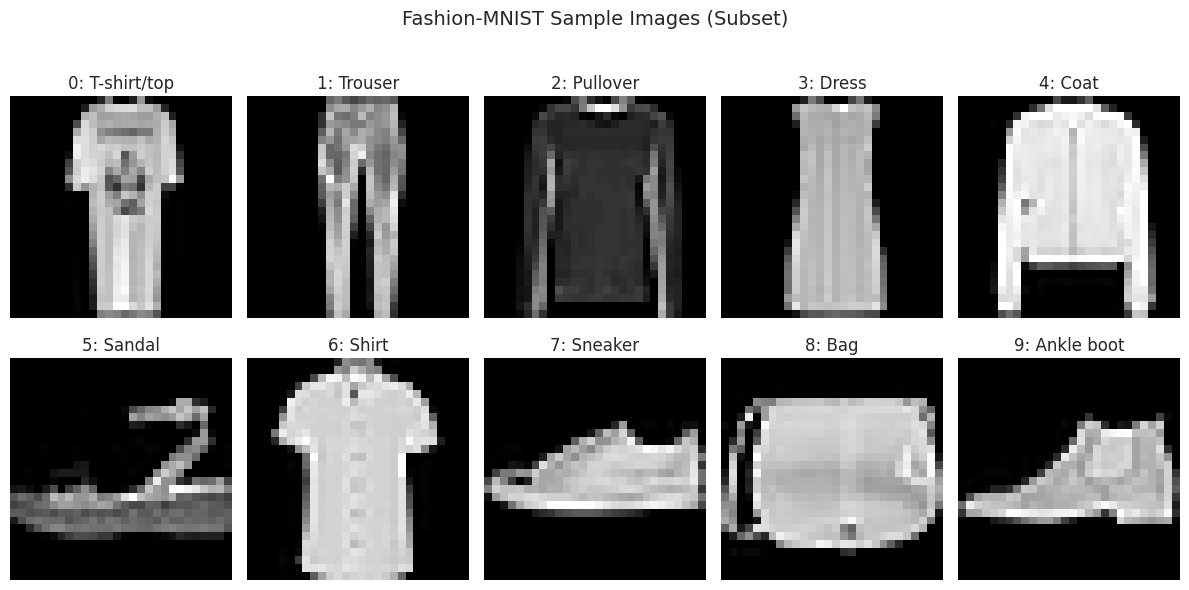

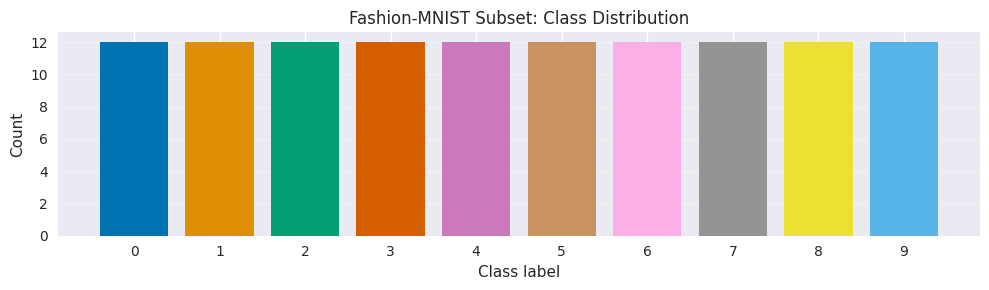

Subset samples: 120
Image dimensions: 28x28 pixels (784 features)
Per-class samples: 12 - 12


In [ ]:
# Visualize sample images from each class (from the subset)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for label in range(10):
    idx = np.where(y_fashion_sub == label)[0][0]
    image = X_fashion_sub[idx].reshape(28, 28)
    axes[label].imshow(image, cmap="gray")
    axes[label].set_title(f"{label}: {fashion_class_names[label]}")
    axes[label].axis("off")

plt.suptitle("Fashion-MNIST Sample Images (Subset)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Class distribution in subset
fig, ax = plt.subplots(figsize=(10, 3))
class_counts_fashion = pd.Series(y_fashion_sub).value_counts().sort_index()
ax.bar(class_counts_fashion.index, class_counts_fashion.values, color=sns.color_palette("colorblind", 10))
ax.set_xlabel("Class label")
ax.set_ylabel("Count")
ax.set_title("Fashion-MNIST Subset: Class Distribution")
ax.set_xticks(range(10))
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Subset samples: {len(X_fashion_sub)}")
print(f"Image dimensions: 28x28 pixels ({X_fashion_sub.shape[1]} features)")
print(f"Per-class samples: {class_counts_fashion.min()} - {class_counts_fashion.max()}")

### Visualizing the Fashion-MNIST Dataset

Let's explore Fashion-MNIST visually to understand:

- What the 28×28 grayscale clothing images look like.
- The distribution of samples across the 10 classes.

These visualizations help verify the data loaded correctly and give intuition about the patterns the models will learn.


We will train the same four model families with Fashion-MNIST-friendly hyperparameters. Logistic Regression and MLP use standardized features, while tree ensembles operate on the raw pixel intensities.



Logistic Regression (L2) metrics:
   Accuracy: 0.625
  Precision: 0.660
     Recall: 0.625
         F1: 0.617
    ROC_AUC: 0.908


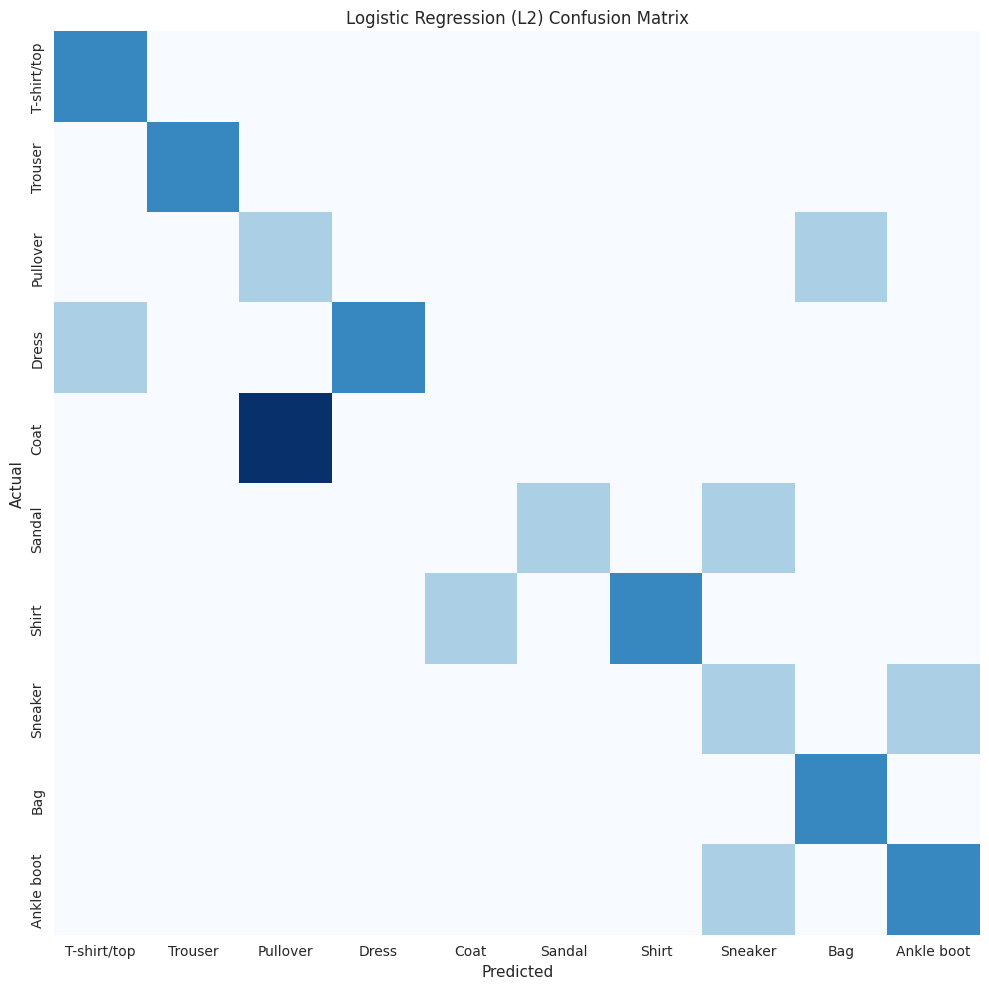


MLP (128-64 ReLU) metrics:
   Accuracy: 0.458
  Precision: 0.424
     Recall: 0.458
         F1: 0.421
    ROC_AUC: 0.928


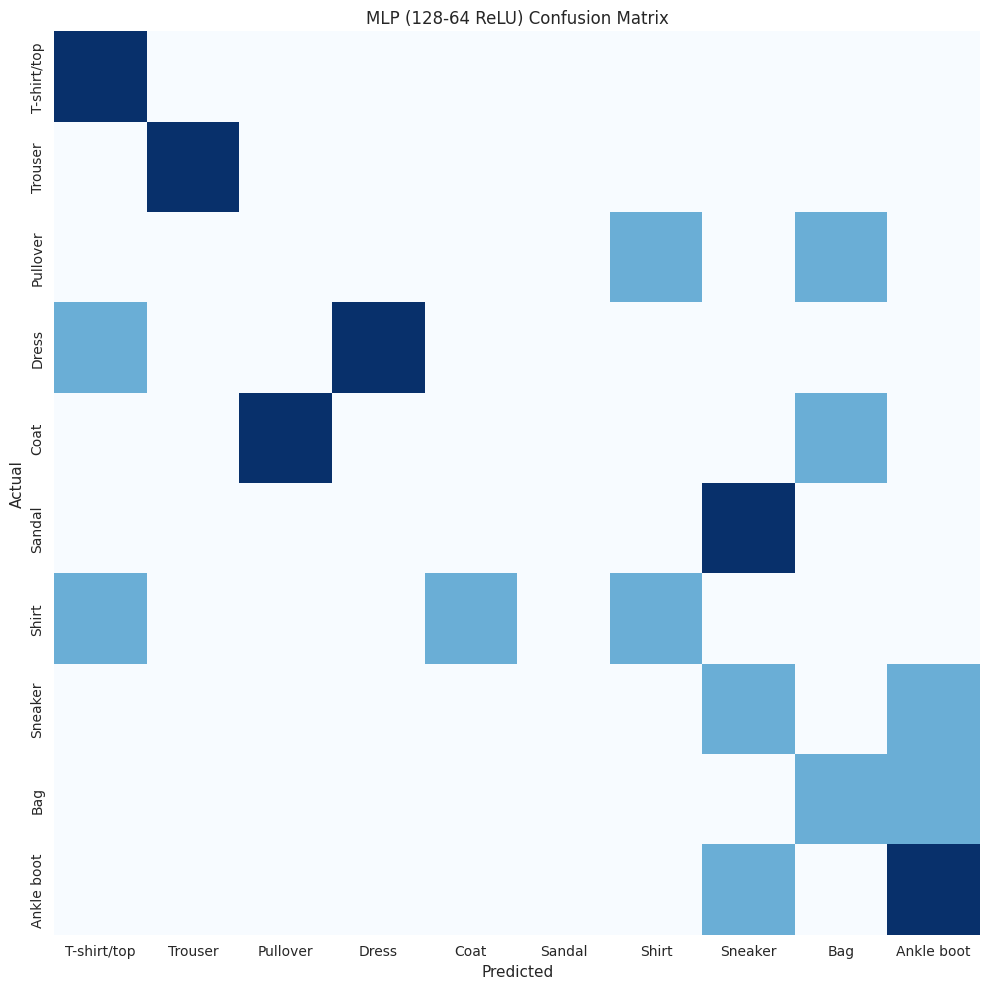


Random Forest (200 trees) metrics:
   Accuracy: 0.583
  Precision: 0.545
     Recall: 0.583
         F1: 0.550
    ROC_AUC: 0.961


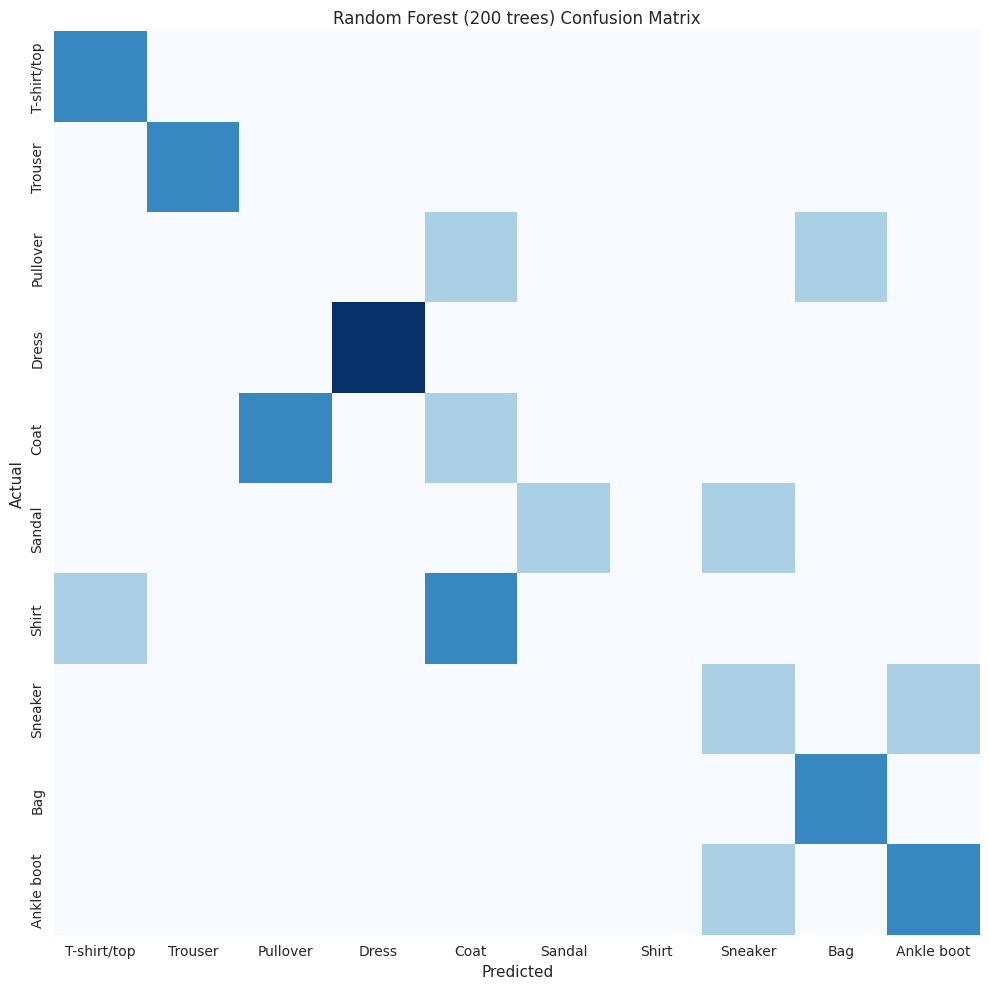


Gradient Boosting (150 stg) metrics:
   Accuracy: 0.750
  Precision: 0.743
     Recall: 0.750
         F1: 0.742
    ROC_AUC: 0.920


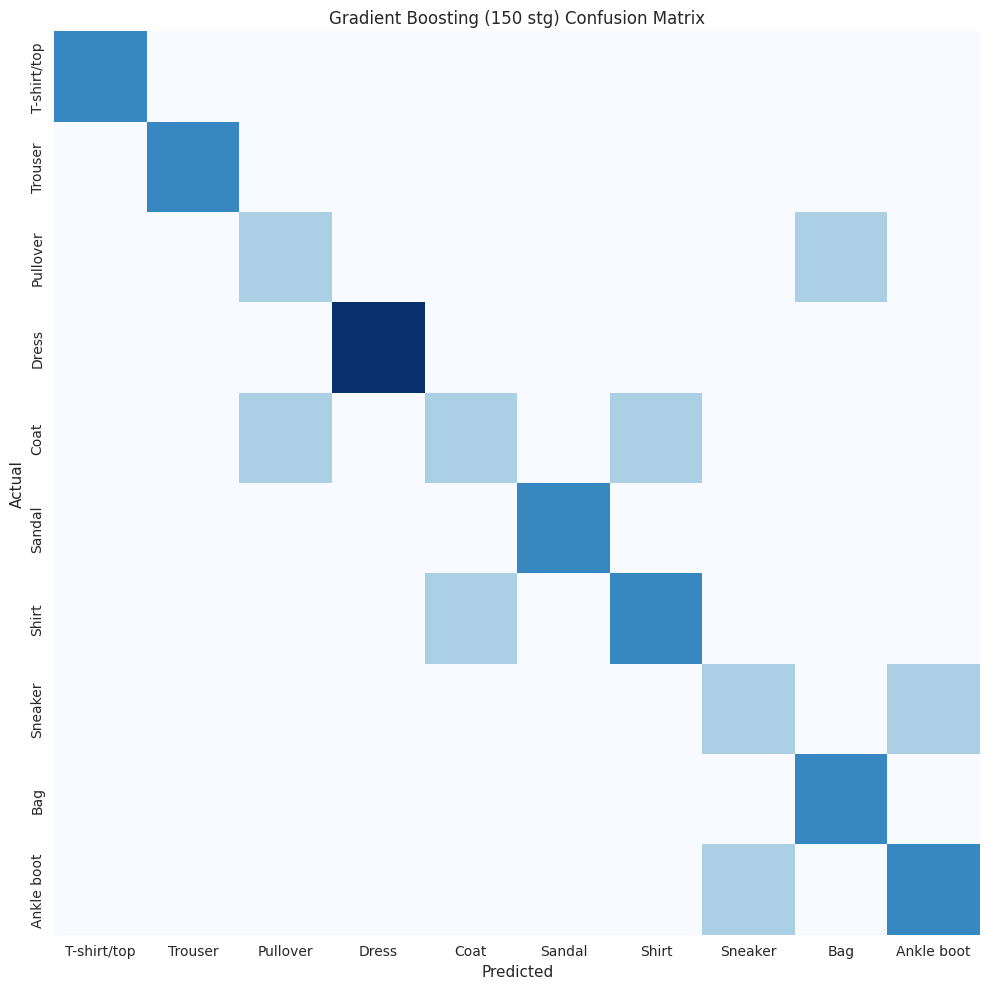

In [ ]:
fashion_results = []

fashion_experiments = [
    (
        "Logistic Regression (L2)",
        LogisticRegression(solver="lbfgs", max_iter=600, C=1.0),
        X_train_fashion_scaled,
        y_train_fashion,
        X_test_fashion_scaled,
        y_test_fashion,
    ),
    (
        "MLP (128-64 ReLU)",
        MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            alpha=1e-4,
            learning_rate_init=1e-3,
            early_stopping=True,
            max_iter=80,
            random_state=42,
        ),
        X_train_fashion_scaled,
        y_train_fashion,
        X_test_fashion_scaled,
        y_test_fashion,
    ),
    (
        "Random Forest (200 trees)",
        RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=42,
        ),
        X_train_fashion,
        y_train_fashion,
        X_test_fashion,
        y_test_fashion,
    ),
    (
        "Gradient Boosting (150 stg)",
        GradientBoostingClassifier(
            learning_rate=0.05,
            n_estimators=150,
            max_depth=2,
            subsample=0.7,
            max_features="sqrt",
            random_state=42,
        ),
        X_train_fashion,
        y_train_fashion,
        X_test_fashion,
        y_test_fashion,
    ),
]

for name, estimator, X_tr, y_tr, X_te, y_te in fashion_experiments:
    train_and_evaluate(
        name=name,
        estimator=estimator,
        X_train=X_tr,
        y_train=y_tr,
        X_test=X_te,
        y_test=y_te,
        class_names=fashion_class_names,
        results_store=fashion_results,
    )

In [ ]:
fashion_results_df = pd.DataFrame(fashion_results).set_index("Model").sort_values("Accuracy", ascending=False)
fashion_results_df

,Accuracy,Precision,Recall,F1,ROC_AUC,Train size,Test size
Model,,,,,,,
Gradient Boosting (150 stg),0.750000,0.743056,0.750000,0.741667,0.920274,96,24
Logistic Regression (L2),0.625000,0.659722,0.625000,0.616667,0.907828,96,24
Random Forest (200 trees),0.583333,0.545139,0.583333,0.549603,0.961400,96,24
MLP (128-64 ReLU),0.458333,0.423611,0.458333,0.421429,0.927561,96,24


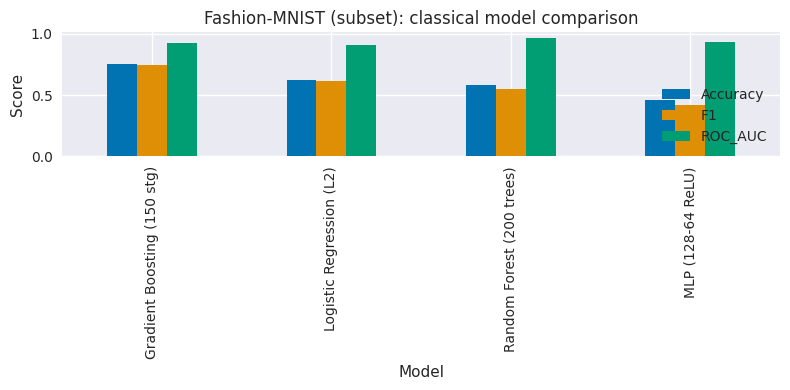

In [ ]:
fashion_metrics_to_plot = ["Accuracy", "F1", "ROC_AUC"]
fig, ax = plt.subplots(figsize=(8, 4))
fashion_results_df[fashion_metrics_to_plot].plot(kind="bar", ax=ax)
ax.set_ylim(0.0, 1.01)
ax.set_ylabel("Score")
ax.set_title("Fashion-MNIST (subset): classical model comparison")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

**Reading the Fashion-MNIST results**

- Logistic Regression is a strong baseline once pixels are standardized, but it remains a linear classifier in pixel space.
- MLPs often improve accuracy by learning nonlinear combinations of pixels, especially with enough data and proper regularization.
- Random Forests can work without scaling but may struggle with high-dimensional pixel inputs unless you grow many trees.
- Boosting can be competitive, but it is sequential and can be slower to tune—try adjusting `learning_rate` and `n_estimators` and re-run to see the trade-offs.


## 11. Reflection Prompts and Next Steps

1. **Data fit:** Which model handled the malignant class best? Inspect the confusion matrices for false negatives.
2. **Explainability:** If a clinician demanded feature rankings, which models would you pick and why?
3. **Operational constraints:** Suppose inference must run on a Raspberry Pi. Which algorithm is the safest choice?
4. **Experiment idea:** Tune one model family (e.g., change `C` in Logistic Regression, grow more trees in Random Forest, or adjust `learning_rate` in Boosting) and justify your choice using the dashboard metrics.

### Checklist Before You Move On

- [ ] Re-ran at least one training cell with modified hyperparameters.
- [ ] Captured screenshots or notes about the performance dashboard.
- [ ] Reflected on deployment constraints (latency, interpretability, retraining cadence).

> **Stretch goal:** Integrate SHAP (from Lesson 05) with one of the tree-based models here to unify interpretability insights across the course.


---

### Key Takeaways

- Logistic Regression is a fast, interpretable baseline with probabilistic outputs; scaling matters.
- MLPs propagate information through repeated linear + non-linear transformations; scaling and optimizer settings are pivotal.
- Tree ensembles (Random Forest, Gradient Boosting) remain strong baselines for tabular biomedical data with minimal preprocessing.
- Building a reusable evaluation harness accelerates fair comparisons and makes notebook lessons interactive.
